In [1]:
import numpy as np 
import struct
from array import array
from os.path  import join

class MnistDataloader(object):
    def __init__(self, training_images_filepath,training_labels_filepath,
                 test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath
    
    def read_images_labels(self, images_filepath, labels_filepath):        
        labels = []
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = array("B", file.read())        
        
        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())        
        images = []
        for i in range(size):
            images.append([0] * rows * cols)
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
            img = img.reshape(28, 28)
            images[i][:] = img            
        
        return images, labels
            
    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        return (x_train, y_train),(x_test, y_test) 

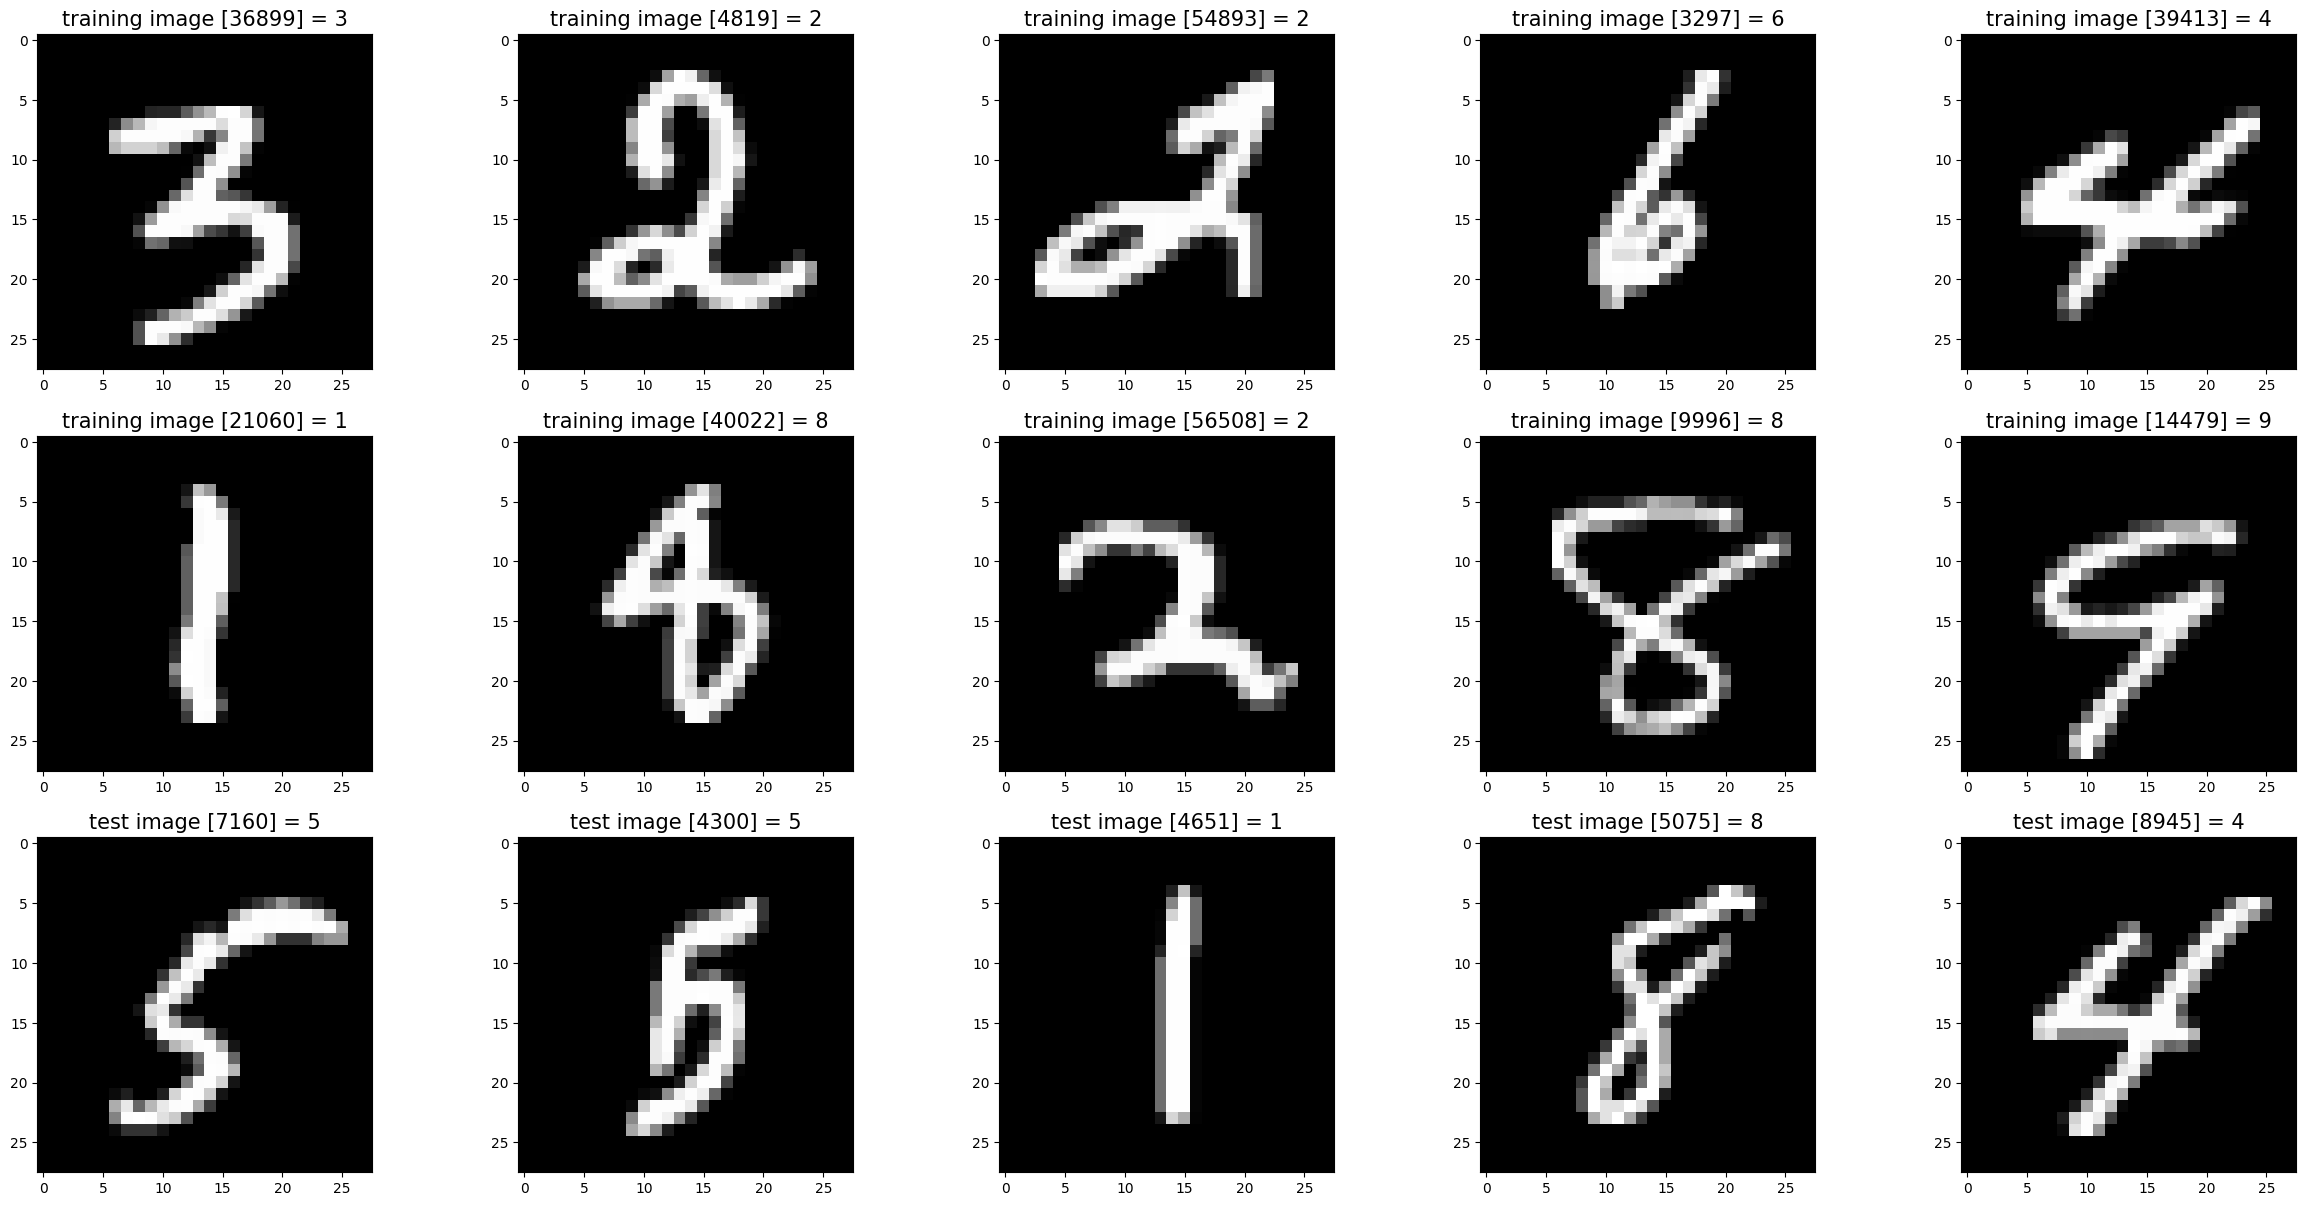

In [2]:
%matplotlib inline
import random
import matplotlib.pyplot as plt

training_images_filepath = r"D:\Work\BaiTapPhongVan\MNIST\Input\train-images.idx3-ubyte"
training_labels_filepath = r"D:\Work\BaiTapPhongVan\MNIST\Input\train-labels.idx1-ubyte"
test_images_filepath = r"D:\Work\BaiTapPhongVan\MNIST\Input\t10k-images.idx3-ubyte"
test_labels_filepath = r"D:\Work\BaiTapPhongVan\MNIST\Input\t10k-labels.idx1-ubyte"

def show_images(images, title_texts):
    cols = 5
    rows = int(len(images)/cols) + 1
    plt.figure(figsize=(30,20))
    index = 1    
    for x in zip(images, title_texts):        
        image = x[0]        
        title_text = x[1]
        plt.subplot(rows, cols, index)        
        plt.imshow(image, cmap=plt.cm.gray)
        if (title_text != ''):
            plt.title(title_text, fontsize = 15);        
        index += 1

mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(x_train, y_train), (x_test, y_test) = mnist_dataloader.load_data()

images_2_show = []
titles_2_show = []
for i in range(0, 10):
    r = random.randint(1, 60000)
    images_2_show.append(x_train[r])
    titles_2_show.append('training image [' + str(r) + '] = ' + str(y_train[r]))    

for i in range(0, 5):
    r = random.randint(1, 10000)
    images_2_show.append(x_test[r])        
    titles_2_show.append('test image [' + str(r) + '] = ' + str(y_test[r]))    

show_images(images_2_show, titles_2_show)

Accuracy on train: 95.77%
Accuracy on val: 83.10%


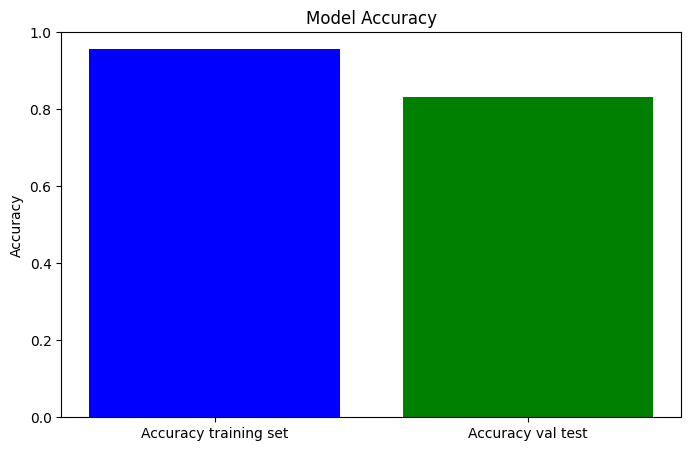

In [3]:
import numpy as np
import matplotlib.pyplot as plt

class NaiveBayesClassifier:
    def __init__(self, alpha=1e-5):
        self.alpha = alpha  

    def fit(self, X_train, y_train):
        X_train = np.array(X_train)
        y_train = np.array(y_train).flatten()
        
        num_samples, num_features = X_train.shape
        self.classes, counts = np.unique(y_train, return_counts=True)
        num_classes = len(self.classes)
        
        self.class_probs = counts / num_samples
        self.feature_probs = np.zeros((num_classes, num_features, 256))  

        for c in range(num_classes):
            X_c = X_train[y_train == self.classes[c]]
            for i in range(num_features):
                for value in range(256):
                    self.feature_probs[c, i, value] = (np.sum(X_c[:, i] == value) + self.alpha) / (X_c.shape[0] + 256 * self.alpha)

    def predict(self, X_test):
        X_test = np.array(X_test)
        num_samples, num_features = X_test.shape
        num_classes = len(self.classes)
        
        log_probs = np.zeros((num_samples, num_classes))
        
        for c in range(num_classes):
            class_prob = np.log(self.class_probs[c])
            feature_probs = np.sum(np.log(self.feature_probs[c, np.arange(num_features), X_test]), axis=1)
            log_probs[:, c] = class_prob + feature_probs
        
        return self.classes[np.argmax(log_probs, axis=1)]

x_train_normalized = (x_train / np.max(x_train) * 255).astype(int)
x_test_normalized = (x_test / np.max(x_test) * 255).astype(int)

x_train_flat = x_train_normalized.reshape(len(x_train_normalized), -1)
x_test_flat = x_test_normalized.reshape(len(x_test_normalized), -1)

nb = NaiveBayesClassifier(alpha=1e-5)
nb.fit(x_train_flat, y_train)

y_pred = nb.predict(x_test_flat)

y_train_pred = nb.predict(x_train_flat)
train_accuracy = np.mean(y_train_pred == y_train)

test_accuracy = np.mean(y_pred == y_test)

print(f"Accuracy on train: {train_accuracy * 100:.2f}%")
print(f"Accuracy on val: {test_accuracy * 100:.2f}%")

plt.figure(figsize=(8, 5))
plt.bar(['Accuracy training set', 'Accuracy val test'], [train_accuracy, test_accuracy], color=['blue', 'green'])
plt.ylim(0, 1)
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.show()

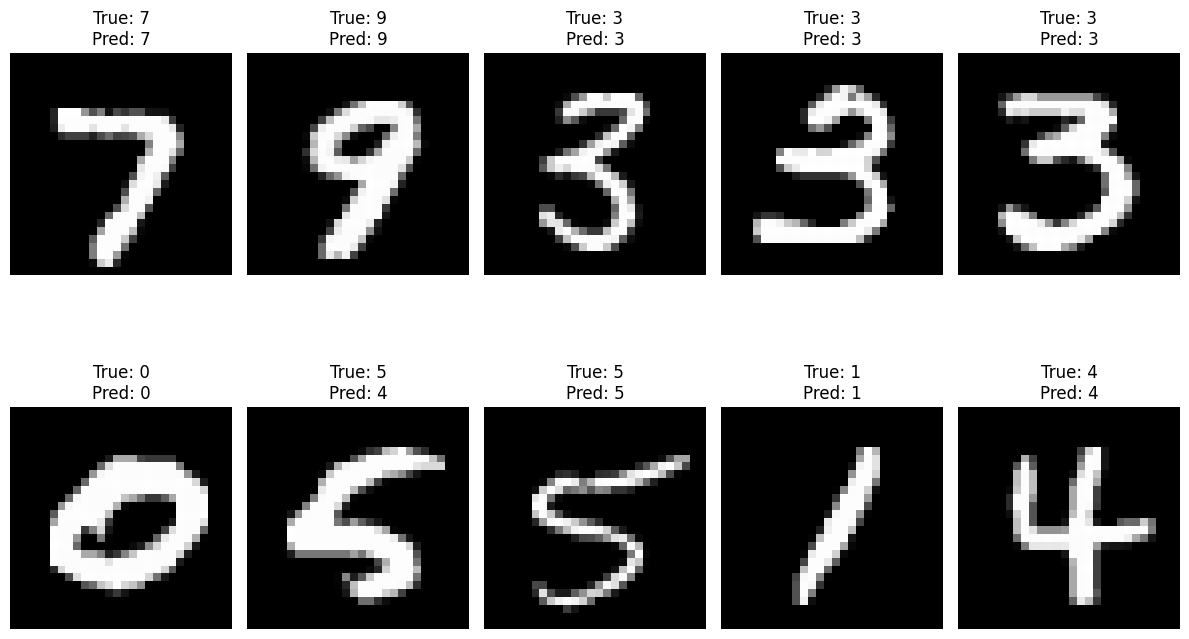

In [4]:
x_test = np.array(x_test)
y_test = np.array(y_test)

num_samples_to_test = 10  # modify sample here
indices = np.random.choice(range(len(x_test)), num_samples_to_test, replace=False)

sample_images = x_test[indices]
sample_labels = y_test[indices]

sample_images_flat = x_test_flat[indices]
predicted_labels = nb.predict(sample_images_flat)

plt.figure(figsize=(12, 8))
for i in range(num_samples_to_test):
    plt.subplot(2, num_samples_to_test // 2, i + 1)
    plt.imshow(sample_images[i], cmap='gray')
    plt.title(f"True: {sample_labels[i]}\nPred: {predicted_labels[i]}")
    plt.axis('off')

plt.tight_layout()
plt.show()